# Possion Equation for Dipole

Numerically calculate the electric potential of a static electric dipole, i.e. two point charges $Q/\epsilon_0 = \pm 1$ separated by a distance of $a= 0.6$. Solve the Poisson equation in Cartesian coordinates, but impose a spherical boundary condition, $V(R) = 0$, at a large distance (e.g. $R = 10$).

Starting from an initial condition of zero potential use the Jacobi relaxation algorithm with appropriate numerical tolerance and grid density to obtain the (converged) solution.

Consider a square with side length equal to 20 since the radius of the boundary circular ring is 10. Assume the two point charges are on the y-axis and symmetric with respect to the origin. A matrix Rho is created to save charge densities on different sites of the grid. All of its elements are zero except for the two charge spots. Two matrices $V_{old}$ and $V_{new}$ are created to save old and new potentials on different sites of the grid. To satisfy the boundary condition, the elements spotting on the boundary circular ring are zero all the time. 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
a = 0.6 # distance between two point charges
R = 10 # radius of the boundary circular ring

# # 

Poisson's equation for electrostatics is
$$
\nabla^2V =(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2})V = -\frac{\rho}{\epsilon}
$$
The recursion formula used to calcuate potential based on Jacobi Relaxation algorithm is
$$
V_{new}(i,j)=\frac{1}{4}[V_{old}(i-1,j)+V_{old}(i+1,j)+V_{old}(i,j-1)+V_{old}(i, j+1)]+Rho(i,j)
$$

In [3]:
def getNextV_Jacobi(V, x, y, Rho):
    """
    calculate new potential values base on the old ones (Jacobi Relaxation method)
    """
    row, column = V.shape[0], V.shape[1]
    V_new = np.zeros((row, column), dtype=np.float64)
    for i in range(1,row-1):
        for j in range(1, column-1):
            if y[i]**2+x[j]**2 < R**2:
                V_new[i,j] = (V[i-1,j]+V[i+1,j]+V[i,j-1]+V[i,j+1])/4 + Rho[i,j] 
    return V_new

In [4]:
def error_sum(V1, V2):
    return np.sum(abs(V1-V2))

In [5]:
def error_max(V1, V2):
    return np.max(abs(V1-V2))

In [6]:
def convergedV(N, getNext, error_fun, tolarence=0.0001):
    da = 2*R/(N-1) # side length of each grid 
    x = np.arange(-R, R+da, da) # divide the sapce uniformly into N parts in x-direction
    y = np.arange(-R, R+da, da) # divide the sapce uniformly into N parts in y-direction
    Ex = N//2 # position of the charges in x-direction
    Ey = int(Ex+a/(2*da)+1) # position of the charges in y-direction
    E_y = int(Ex-a/(2*da))
    Rho = np.zeros((N,N), dtype=np.float64) # a matrix to store charge dencities
    Rho[Ex, Ey] = -1 # put the two nonzero charge dencities in the matrix
    Rho[Ex, E_y] = 1

    V = np.zeros((N, N), dtype=np.float64) # record old potential values
    
    deltaV = 1
    iter_num = 0
    while deltaV > tolarence:
        Vnew = getNext(V, x, y, Rho)
        deltaV = error_fun(Vnew, V)
        V = np.copy(Vnew)
        iter_num += 1
    return Vnew, iter_num, x, y

In [7]:
V_new, iter_num, x, y = convergedV(101, getNextV_Jacobi, error_sum)

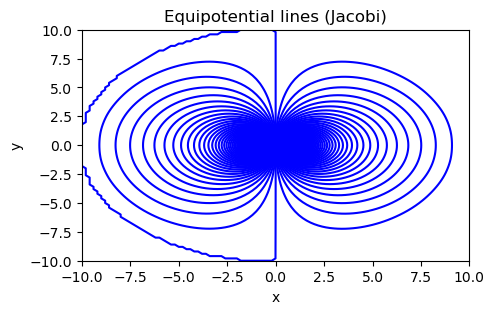

In [8]:
X,Y = np.meshgrid(x,y)
plt.figure(figsize=(5,3))
plt.contour(X, Y, V_new, 400, colors = 'b', linestyles = 'solid')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Equipotential lines (Jacobi)')
plt.savefig('figure1_a1.pdf')
plt.show()

Investigate how the number of required iteration steps, $N_{iter}$, increases with reducing the tolerance (error) limit.

# #

In [9]:
error = 0.00001*np.linspace(1, 1000, 50)
length = len(error)
N_iter = np.zeros(length)
for e in range(length):
    V_new, iter_num, x, y = convergedV(101, getNextV_Jacobi, error_sum, error[e])
    N_iter[e] = iter_num    

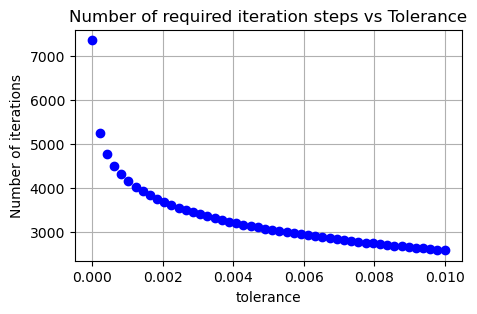

In [10]:
plt.figure(figsize=(5,3))
plt.plot(error, N_iter, 'ob')
plt.xlabel('tolerance')
plt.ylabel('Number of iterations')
plt.title('Number of required iteration steps vs Tolerance')
plt.grid()
plt.show()

# #

Modify the algorithm to use the Simultaneous Over-Relaxation Method(SOR), and allow for different grid densities in different relaxation runs. 
Recursion formula of Simultaneous Over-relaxation method is 
$$
V_{new}(i,j) = \alpha\Delta V(i,j) + V_{old}(i,j) + Rho(i,j) \\
= \alpha{[V_{old}(i+1,j)+V_{new}(i-1,j)+V_{old}(i,j+1)+V_{new}(i,j-1)]/4-V_{old}(i,j)}+V_{old}(i,j)+Rho(i,j)
$$
where $\alpha\in(1.2, 1.5)$ ($N$ is the number of grid points) measures how much we over-relax. 
Simultaneous Over-Relaxation method is more efficient than Jacobi Relaxation method

In [11]:
def getNextV_SOR(V, x, y, Rho):
    """
    calculate new potential values base on the old ones (Simultaneously Over Relaxation method)
    """
    row, column = V.shape[0], V.shape[1]
    V_new = np.zeros((row, column), dtype=np.float64)
    for i in range(1,row-1):
        for j in range(1, column-1):
            if y[i]**2+x[j]**2 < R**2:
                V_new[i,j] = 1.5*((V_new[i-1,j]+V[i+1,j]+V_new[i,j-1]+V[i,j+1])/4 -V[i,j]) + V[i,j] + Rho[i,j]
    return V_new

In [12]:
V_new, iter_num, x, y = convergedV(101, getNextV_SOR, error_sum)

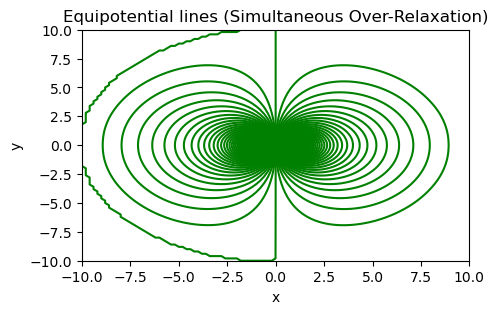

In [13]:
X,Y = np.meshgrid(x,y)
plt.figure(figsize=(5,3))
plt.contour(X, Y, V_new, 400, colors = 'g', linestyles = 'solid')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Equipotential lines (Simultaneous Over-Relaxation)')
plt.savefig('figure1_a1.pdf')
plt.show()

# #

In [14]:
error = 0.00001*np.linspace(1, 1000, 50)
length = len(error)
N_iter = np.zeros(length)
for e in range(length):
    V_new, iter_num, x, y = convergedV(101, getNextV_SOR, error_sum, error[e])
    N_iter[e] = iter_num  

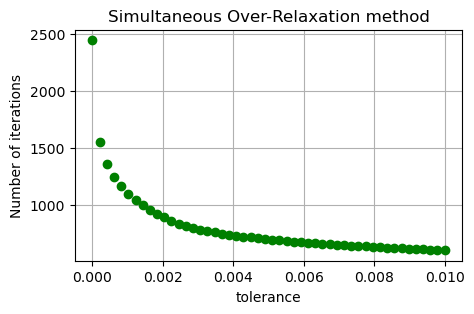

In [15]:
plt.figure(figsize=(5,3))
plt.plot(error, N_iter, 'og')
plt.xlabel('tolerance')
plt.ylabel('Number of iterations')
plt.title('Simultaneous Over-Relaxation method')
plt.grid()
plt.show()